In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

Segmentation Models: using `tf.keras` framework.


In [2]:
SIZE_X = 512
SIZE_Y = 512
n_classes = 3
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [3]:
def preprocess_and_augment(image, mask):
    print(mask.shape)
    image = image / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    mask = tf.cast(mask, tf.float32)
    print(mask.shape)
    mask = tf.where(mask == 3, 0.0, mask)  # Set 3 to 0.0
    mask = tf.where(mask == 4, 0.0, mask)  # Set 4 to 0.0
    mask = tf.where(mask == 5, 0.0, mask)  # Set 5 to 0.0
    mask = tf.where(mask == 6, 2.0, mask)  # Set 6 to 2.0
    mask = tf.where(mask == 7, 0.0, mask)
    print(mask.shape)
    mask = tf.squeeze(mask, axis=-1)
    print(mask.shape)
    mask = tf.one_hot(tf.cast(mask, tf.int32), depth=n_classes)
    print(mask.shape)
    return image, mask

In [5]:
base_path = "patches"
image_path = os.path.join(base_path, "images")
mask_path = os.path.join(base_path, "masks")

# Loading image datasets
image_dataset = tf.keras.utils.image_dataset_from_directory(
    image_path,
    labels=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=False
)

# Loading mask datasets
mask_dataset = tf.keras.utils.image_dataset_from_directory(
    mask_path,
    labels=None,
    color_mode='grayscale',  # Masks are grayscale
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=False
)

# Combine datasets
dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

# Apply preprocessing
dataset = dataset.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)

# Split into train and validation sets
dataset_size = tf.data.experimental.cardinality(dataset).numpy() * BATCH_SIZE
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size // BATCH_SIZE)
val_dataset = dataset.skip(train_size // BATCH_SIZE)

# Shuffle and prefetch datasets
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

Found 1786 files.
Found 1786 files.
(None, 512, 512, 1)
(None, 512, 512, 1)
(None, 512, 512, 1)
(None, 512, 512)
(None, 512, 512, 3)


In [15]:
img_list=os.listdir('patches/images')

patches\masks\patch_003c44408b3d4c78817ace0b056cec32.png


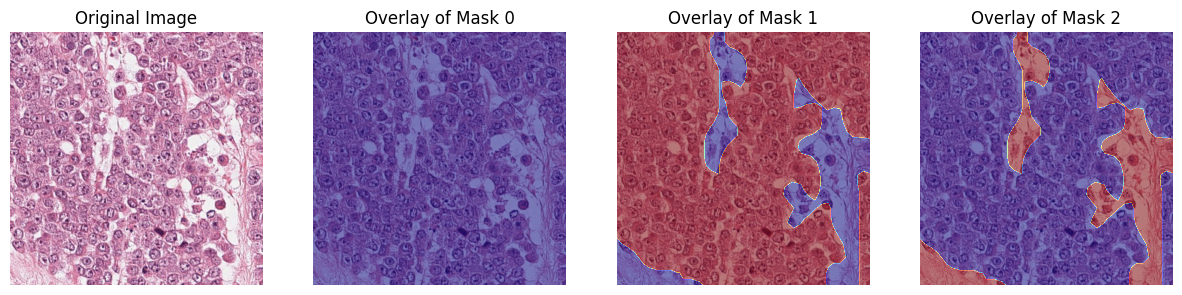

patches\masks\patch_00ce6c83cb024aaa88a7ffaa26345899.png


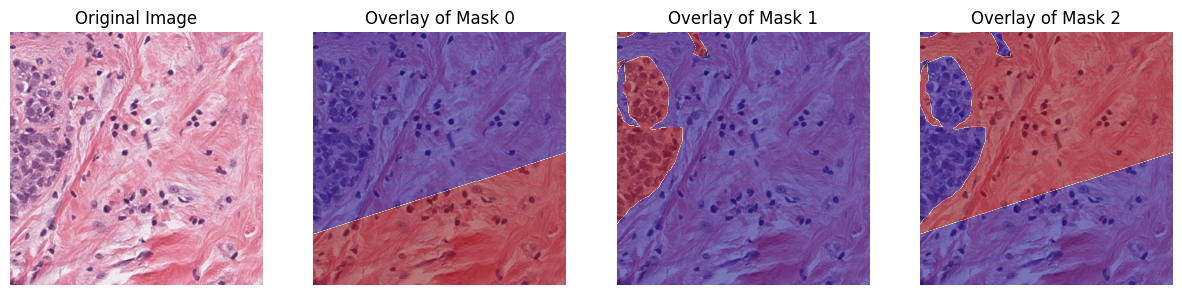

patches\masks\patch_00e7c870f2594d72af963f553d0fa5da.png


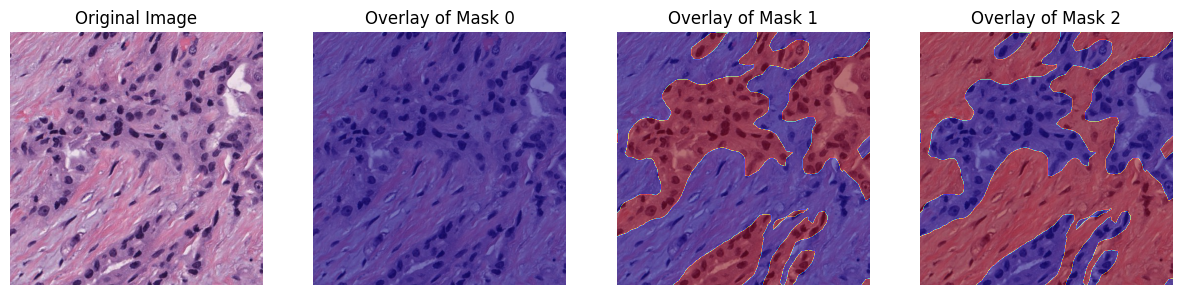

patches\masks\patch_00e94dbbebc14bd2b2481d27834c148e.png


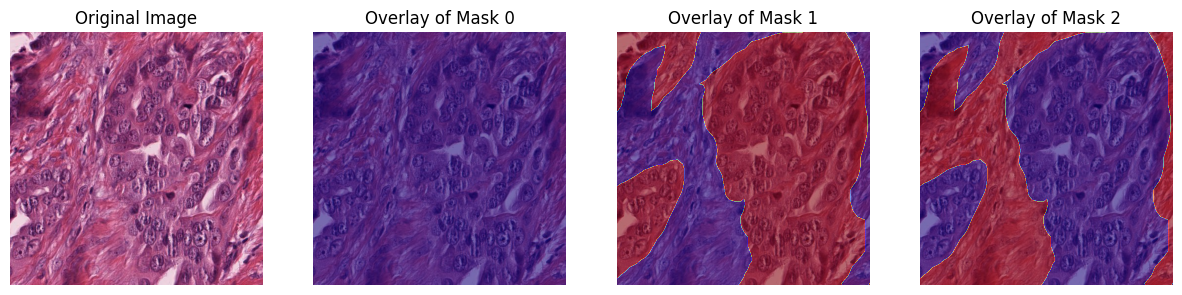

patches\masks\patch_00fa85c511c84a04ad4fd70f8477b527.png


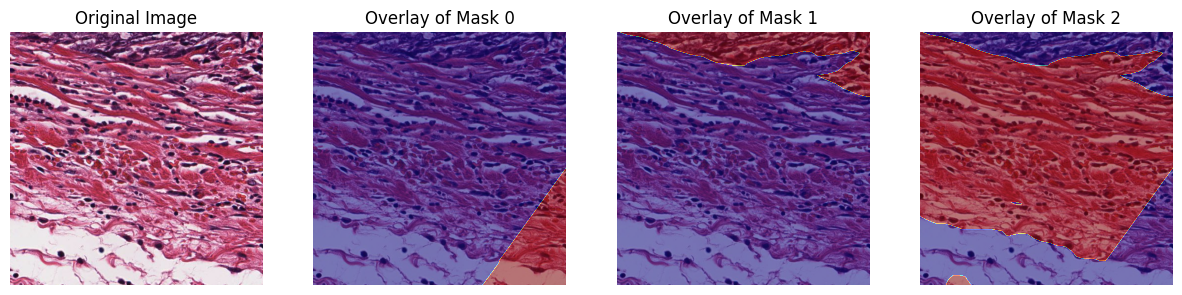

patches\masks\patch_01243d968e7944818f90d5e9620d19f2.png


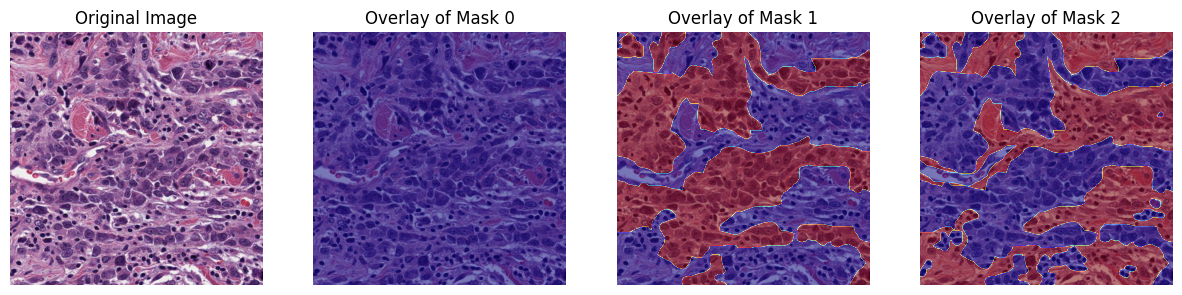

patches\masks\patch_012e4ceddbba49fe9c35168492e31888.png


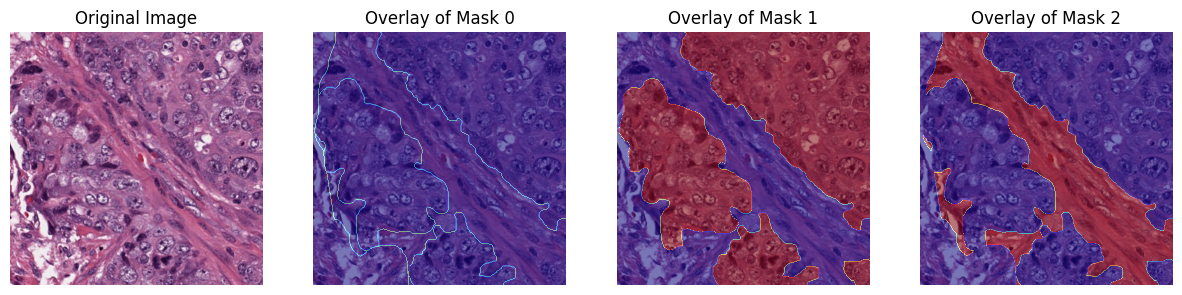

patches\masks\patch_0153baf4c6c3425f9c5b569fdbb3d53d.png


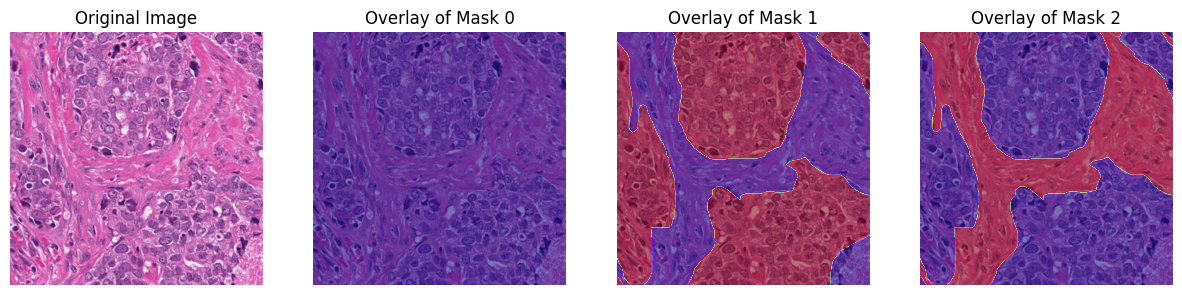

patches\masks\patch_0183cef320be48a3ae21a7dc40ca769c.png


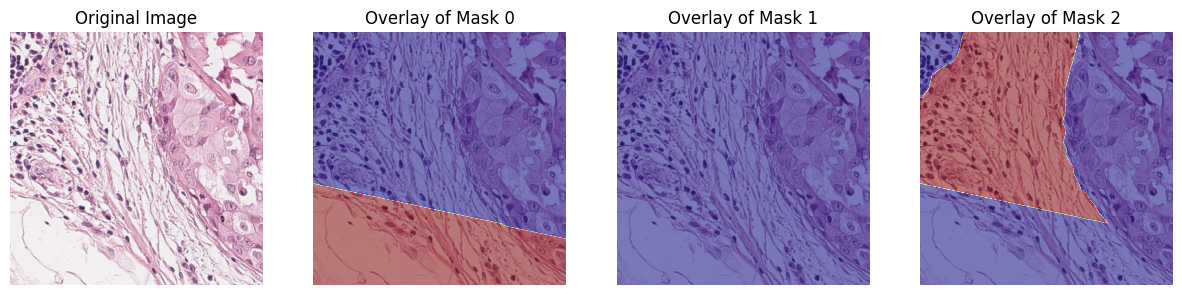

patches\masks\patch_01d5a84024ca4c91b837116769a1dc33.png


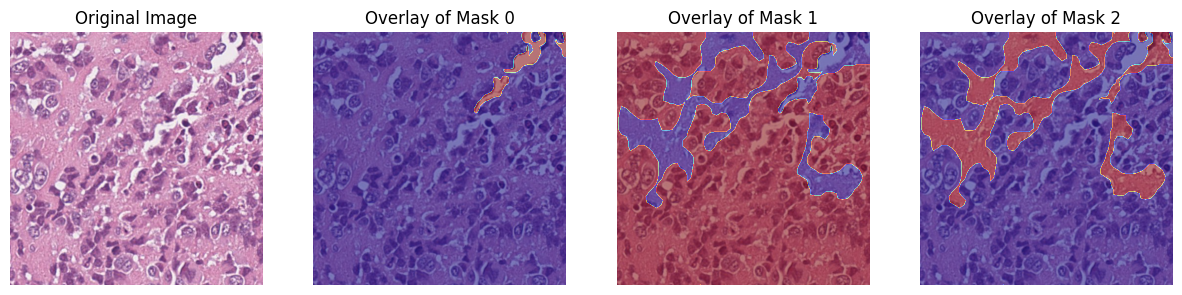

In [24]:
for pth in img_list[0:10]:
    print(os.path.join('patches\masks',pth))
    msk=cv2.imread(os.path.join('../tiger_grand_challenge/patches/masks/',pth))
    img=cv2.imread(os.path.join('../tiger_grand_challenge/patches/images/',pth))
    msk=cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
    msk = tf.one_hot(tf.cast(msk, np.int32), depth=7)
    plt.figure(figsize=(15, 15))

    # Plot original image
    plt.subplot(1, 4, 1)  # Subplot for the image
    plt.imshow(img)  # Show the image in RGB
    plt.title("Original Image")
    plt.axis('off')

    # Loop through each mask channel and overlay on the image
    for i in range(n_classes):  # Assuming 7 classes/mask channels
        plt.subplot(1, 4, i+2)  # Subplots for each mask
        plt.imshow(img)  # Show the original image
        plt.imshow(msk[:, :, i], cmap='jet', alpha=0.5)  # Overlay mask i
        plt.title(f'Overlay of Mask {i}')
        plt.axis('off')
    plt.show()

In [18]:
mask_dataset = tf.keras.utils.image_dataset_from_directory(
    mask_path,
    labels=None,
    color_mode='grayscale',  # Masks are grayscale
    batch_size=BATCH_SIZE,
    image_size=(SIZE_Y, SIZE_X),
    shuffle=True
)

Found 1786 files.


In [19]:
masks = []
for mask_batch in mask_dataset:
    masks.append(mask_batch.numpy())

In [20]:
masks = np.concatenate(masks, axis=0)

In [21]:
def calculate_class_frequencies(masks, n_classes):
    # Initialize an array to store pixel counts for each class
    class_frequencies = np.zeros(n_classes)
    
    # Loop over the masks and count pixels in each class
    for mask in masks:
        # Flatten mask and count occurrences of each class
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique.astype(int), counts):  # Convert cls to int
            if cls < n_classes:  # Ensure cls is within the number of classes
                class_frequencies[cls] += count

    return class_frequencies

def compute_class_weights(frequencies):
    # Inverse frequency to give more weight to less frequent classes
    total_pixels = np.sum(frequencies)
    class_weights = total_pixels / (frequencies + 1e-6)  # Add a small epsilon to avoid division by zero
    
    # Normalize the weights so they sum to 1 (optional)
    class_weights = class_weights / np.sum(class_weights)
    
    return class_weights

def weighted_dice_loss(weights):
    def dice_loss(y_true, y_pred):
        smooth = 1e-6
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)

        # Multiply each class by its corresponding weight
        weighted_true = y_true_f * weights
        weighted_pred = y_pred_f * weights

        intersection = tf.reduce_sum(weighted_true * weighted_pred)
        return 1 - (2. * intersection + smooth) / (tf.reduce_sum(weighted_true) + tf.reduce_sum(weighted_pred) + smooth)

    return dice_loss

# Calculate class frequencies using the masks variable
class_frequencies = calculate_class_frequencies(masks, n_classes)

# Compute class weights based on frequencies
class_weights = compute_class_weights(class_frequencies)

# Create a weighted Dice Loss using the calculated weights
# loss = weighted_dice_loss(class_weights)


In [23]:
np.round(class_weights,3)*100

array([40.1, 30.1, 29.9])

In [ ]:
BACKBONE = 'efficientnetb0'
activation = 'softmax'
encoder_freeze = False
num_classes = 3  # Adjust based on your channel definitions
dropout_value = 0.3
class_weights = np.array([1.6, 1, 0.76])
preprocess_input = sm.get_preprocessing(BACKBONE)
def create_model(dropout_value):
    # Build the model with the specified backbone
    model = sm.Unet(
        backbone_name=BACKBONE,
        input_shape=(SIZE_Y, SIZE_X, 3),  
        encoder_weights='imagenet',
        classes=num_classes,
        activation=None,    
        encoder_freeze=encoder_freeze
    )
    
    model_input = model.input
    model_output = model.get_layer('final_conv').output
    model_output = tf.keras.layers.Dropout(dropout_value)(model_output)
    output = tf.keras.layers.Activation(activation, name=activation)(model_output)

    model_dp = tf.keras.models.Model(model_input, output)
    return model_dp, preprocess_input

# Create the model
model, preprocess_input = create_model(dropout_value)
loss = sm.losses.CategoricalFocalLoss() + sm.losses.DiceLoss(class_weights)  # Combination of losses
metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.summary()

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model_efficient.keras',  
    monitor='val_accuracy', 
    save_best_only=True,  
    mode='max',  
    verbose=1  
)

In [ ]:
# Phase 1: Train decoder with frozen encoder
for layer in model.layers:
    if 'decoder' not in layer.name.split('_'):
        layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset, epochs=15, validation_data=val_dataset,callbacks=[checkpoint])

# Phase 2: Unfreeze encoder and train entire model
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset,callbacks=[checkpoint])
